In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import time
import importlib
plt.style.use('dark_background')

# import pdb

# Hyper Parameters
EPOCH = 30
BATCH_SIZE = 256
LR = 0.001         # learning rate
MNT = 0.9
WD = .0         # weight decay
DOWNLOAD_MNIST = False
N_TEST_IMG = 5
K = 25
m = 500 # Number of atoms
cudaopt = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./data/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                             ]),    
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)



In [2]:
import models as mds
importlib.reload(mds)

# Initialise model
model = (mds.DictLearnt_JIHT(m, K)).to(device)

# Initialise the optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.SGD(model.parameters(), lr=.5, momentum=.9)
loss_func = nn.MSELoss()

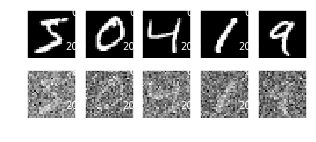

In [3]:
# initialize figure
fig = plt.figure(figsize=(5, 2))

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
view_data = view_data.to(device)
# decoded data is our reconstruction, encoded data is X as it where
decoded_data, encoded_data, errIHT = model(view_data)

# Firstly plot the view data
for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')
# Then plot beneath the 
for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(decoded_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')
    
plt.show()

In [4]:
importlib.reload(mds)

x,y = next(iter(train_loader))
b_x = (x.view(-1, 28*28)).to(device)   # batch x, shape (batch, 28*28)
b_label = (y).to(device)

model.mask = 1
data, decoded, encoded, errJIHT = model.training_forward(b_x, b_label, False, 1)

loss = loss_func(decoded, data)
optimizer.zero_grad()               # clear gradients for this training step
loss.backward()                     # backpropagation, compute gradients
optimizer.step()

print(loss)
print(model.W.grad)


# print(optimizer.step())

# # print(b_x.size())
# # print(decoded.size())
# # print(encoded.size())
# print(errJIHT)
# print(data)
# print(decoded)

tensor(0.8884)
tensor(1.00000e-03 *
       [[ 0.0000,  0.1872,  0.0753,  ..., -0.2057, -0.4588,  0.0000],
        [ 0.0000,  0.1660, -0.1071,  ..., -0.1826, -1.0409,  0.0000],
        [ 0.0000, -0.0413, -0.1739,  ...,  0.0387,  0.0072,  0.0000],
        ...,
        [ 0.0000,  0.1409, -0.0519,  ..., -0.1440, -0.1082,  0.0000],
        [ 0.0000,  0.0742, -0.0222,  ..., -0.0847, -1.3649,  0.0000],
        [ 0.0000,  0.0031, -0.1769,  ..., -0.0276, -0.5865,  0.0000]])


In [5]:
# Training
Error = np.zeros((EPOCH,))
Loss = np.zeros((EPOCH,))
Ts = []
N = train_data.train_data.shape[0] #N = 60,000 in this case
DISPLAY_FREQ = 1 ; #Displaying once per epoch
TSHOW = np.round(DISPLAY_FREQ * N/BATCH_SIZE) # times per EPOCH to display information
t0 = time.perf_counter()
Ts = np.append(Ts,t0)
Err = [] #Initialise list to hold errors
p = 0.1
dropout_on = True
model_filename = "JIHT" + str(np.random.randint(1000000))
print("Running training of model " + model_filename)
print("Number of EPOCHS: " + str(EPOCH))

importlib.reload(mds)

# Begin training loop

for epoch in range(EPOCH):
    if epoch == 10:
        p = 0.3
    elif epoch == 14:
        p = 0.5
    elif epoch == 15:
        print("Turning off dropout")
        dropout_on = False
        p=1
        
    for step, (x, y) in enumerate(train_loader):
        # Think we generate two versions, leaving one unchanged for comparison, not sure what the view is doing      
        b_x = (x.view(-1, 28*28)).to(device)   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, 28*28)).to(device)   # batch y, shape (batch, 28*28)
        b_label = (y).to(device)               # batch label
            
        # Run the data through the model         
        orig_data, decoded, encoded, errJIHT = model.training_forward(b_x, b_label, dropout_on, p)
        
        # Calculate difference between decoded data and genuine data
        loss = loss_func(decoded, orig_data)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        
        # Record loss at each epoch as the loss MSE between decoded and original data         
        Loss[epoch] = Loss[epoch] + loss.data[0]
        # Remove decoded from comp. graph        
        decoded = decoded.detach()
        # Calculate frobenius norm error %, should this not be b_y?       
#         err = np.linalg.norm( (decoded-b_x).cpu().numpy() ,'fro') / np.linalg.norm( b_x.cpu().numpy() ,'fro')
        # Save down the l2 error at each epoch, not quite sure on why errIHT[-1]        
        Error[epoch] = Error[epoch] + errJIHT
        Err = np.append(Err, errJIHT)
    # Not sure quite what is happening here but seems to be averaging the loss and error in some manner?    
    Loss[epoch] /= len(train_loader.dataset)
    Error[epoch] /= (step+1)
    print('Epoch: ', epoch, ', Error: ', Error[epoch], ', | train loss: %.4f' % Loss[epoch], ' NNZ: ', K )

Running training of model JIHT374067
Number of EPOCHS: 30


/Users/mmurray/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  0 , Error:  0.719168814446 , | train loss: 0.0021  NNZ:  25
Epoch:  1 , Error:  0.610013256174 , | train loss: 0.0015  NNZ:  25
Epoch:  2 , Error:  0.591709532129 , | train loss: 0.0014  NNZ:  25
Epoch:  3 , Error:  0.585069528539 , | train loss: 0.0013  NNZ:  25
Epoch:  4 , Error:  0.585815854783 , | train loss: 0.0013  NNZ:  25
Epoch:  5 , Error:  0.583323327531 , | train loss: 0.0013  NNZ:  25
Epoch:  6 , Error:  0.582918158237 , | train loss: 0.0013  NNZ:  25
Epoch:  7 , Error:  0.581599248724 , | train loss: 0.0013  NNZ:  25
Epoch:  8 , Error:  0.581902651077 , | train loss: 0.0013  NNZ:  25
Epoch:  9 , Error:  0.582644896812 , | train loss: 0.0013  NNZ:  25
Epoch:  10 , Error:  0.543741169889 , | train loss: 0.0012  NNZ:  25
Epoch:  11 , Error:  0.522477842392 , | train loss: 0.0011  NNZ:  25
Epoch:  12 , Error:  0.515142201363 , | train loss: 0.0010  NNZ:  25
Epoch:  13 , Error:  0.512542672741 , | train loss: 0.0010  NNZ:  25
Epoch:  14 , Error:  0.496038454771 , | trai

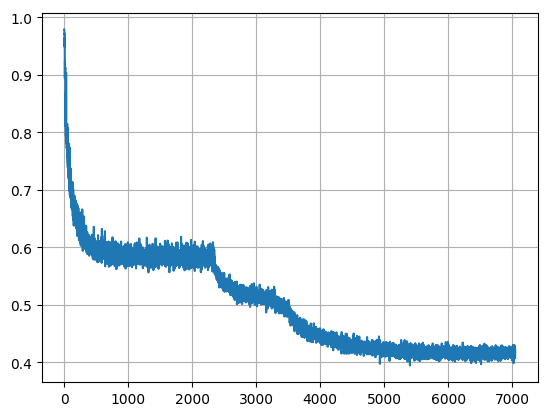

In [6]:
plt.style.use('default'); plt.plot(Err); plt.grid(); plt.show();

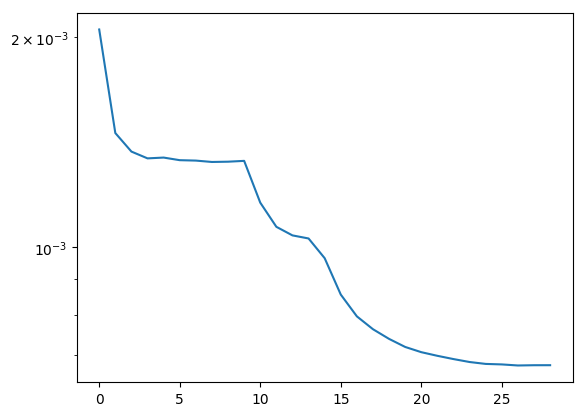

After Training


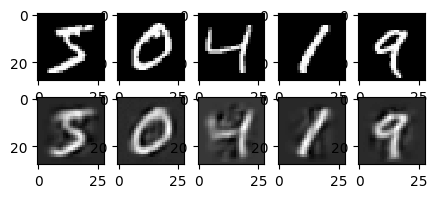

In [7]:
fig = plt.figure()
plt.style.use('default')
plt.semilogy(Loss[0:epoch])
plt.show()

model.mask = torch.ones(N_TEST_IMG, m)

print('After Training')
fig = plt.figure(figsize=(5, 2))
# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = view_data.to(device)
decoded, encoded, errJIHT = model(view_data)

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(decoded.cpu().data.numpy()[i], (28, 28)), cmap='gray')
    
plt.show()

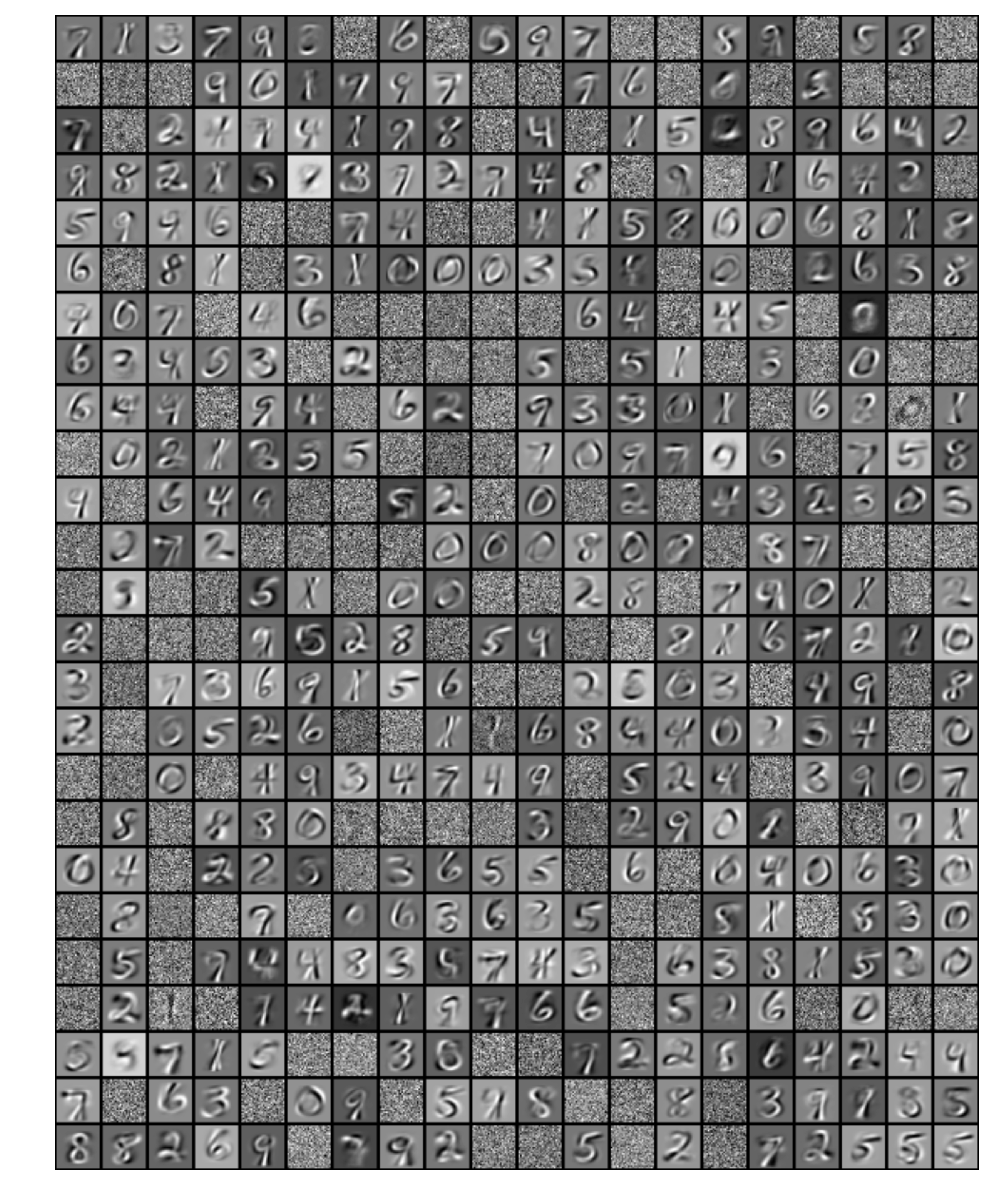

In [8]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

def showFilters(W,ncol,nrows):
    p = int(np.sqrt(W.shape[0]))+2
    Nimages = W.shape[1]
    Mosaic = np.zeros((p*ncol,p*nrows))
    indx = 0
    for i in range(ncol):
        for j in range(nrows):
            im = W[:,indx].reshape(p-2,p-2)
            im = (im-np.min(im))
            im = im/np.max(im)
            Mosaic[ i*p : (i+1)*p , j*p : (j+1)*p ] = np.pad(im,(1,1),mode='constant')
            indx += 1
            
    return Mosaic

W = model.cpu().W.data.numpy()

M1 = showFilters(W,25,20)
plt.figure(figsize=(15,15))
plt.imshow(rescale(M1,4,mode='constant'),cmap='gray')
plt.axis('off')
plt.show()

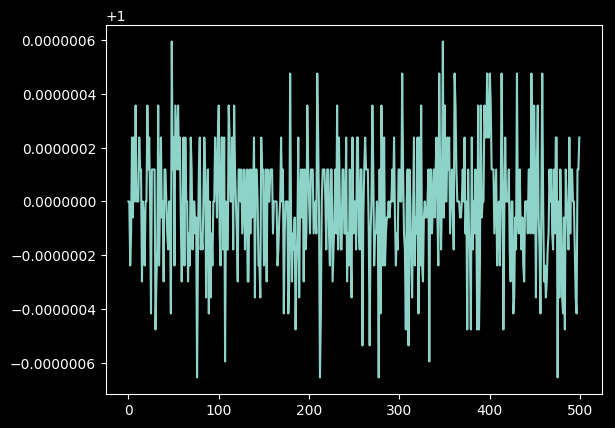

In [9]:
W = model.cpu().W.data.numpy()
Norms = np.sum(W**2,0)**0.5
plt.style.use('dark_background')
plt.plot(Norms)
plt.show()

In [10]:
import auxillary as aux
importlib.reload(aux)

aux.save_model(model, model_filename)

After Training


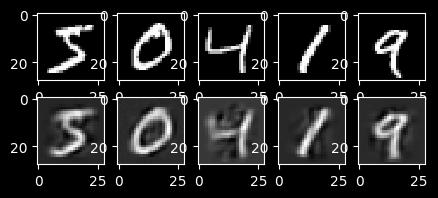

In [11]:
# Check that loading functionality works
importlib.reload(aux)

model2 = aux.load_model(model_filename)

model2.mask = torch.ones(N_TEST_IMG, m)

print('After Training')
fig = plt.figure(figsize=(5, 2))
# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = view_data.to(device)
decoded, encoded, errJIHT = model2(view_data)

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(decoded.cpu().data.numpy()[i], (28, 28)), cmap='gray')
    
plt.show()